# Distribution fitting with pytorch 

## Overview 

Things to try: 
- Change the loss function: loglikelihood loss instead of MSE 
- Min-max scaling
- Increase model capacity
- LBFGS instead of Adam
- Check loss fn


## References: 
- [How to use Pytorch as a general optimizer](https://towardsdatascience.com/how-to-use-pytorch-as-a-general-optimizer-a91cbf72a7fb)
- [pytorch Adam vs LBFGS](https://soham.dev/posts/linear-regression-pytorch/)

In [1]:
import numpy as np
from scipy.stats import weibull_min, beta, gaussian_kde
import torch
import torch.nn as nn
from torch.functional import F
from torch.autograd import Variable
import plotly.graph_objects as go
import matplotlib.pyplot as plt 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data setup 

In [2]:
np.random.seed(2023)

n = 1000
shape = .8
scale = 1

/opt/conda/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:2108: RuntimeWarning: divide by zero encountered in power
  return c*pow(x, c-1)*np.exp(-pow(x, c))


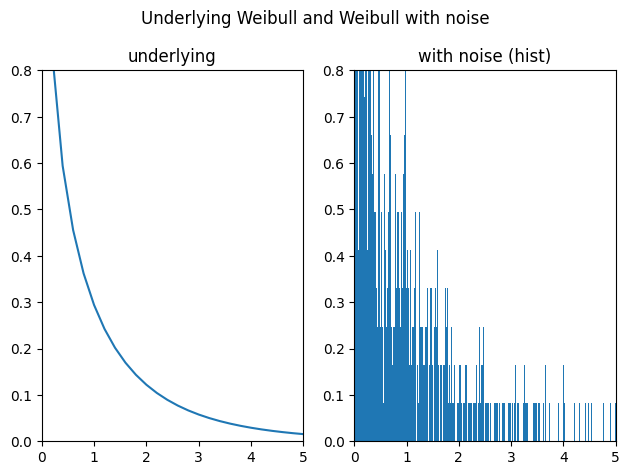

In [3]:
#generate points for weibull, set location parameter to 0 - this is 2-parameter because loc is 0
weibull_data = weibull_min.rvs(c=shape, scale=scale, loc=0, size=n)

#add noise, mean = 0, sd = 0.1 for the same sample size
noise = np.random.normal(0, 0.1, n)  
weibull_data = weibull_data + noise
#all positive data
weibull_data = np.abs(weibull_data) + 1e-4

#generate the x values to be used for generating the pdf
curve_x = np.linspace(0, 200, 1000)
#generate the pdf with the same parameters that were used for generating the data
weibull_pdf = weibull_min.pdf(curve_x, shape, scale=scale)

title='Underlying Weibull and Weibull with noise'
subs = ['underlying', 'with noise (hist)']
fig, ax = plt.subplots(1, 2)
ax[0].plot(curve_x, weibull_pdf)
ax[1].hist(weibull_data, bins=1000, density=True)

for idx in range(2): 
    ax[idx].set_xlim(0, 5)
    ax[idx].set_ylim(0, .80)
    ax[idx].set_title(subs[idx])
plt.suptitle(title)
fig.tight_layout()
fig.show()

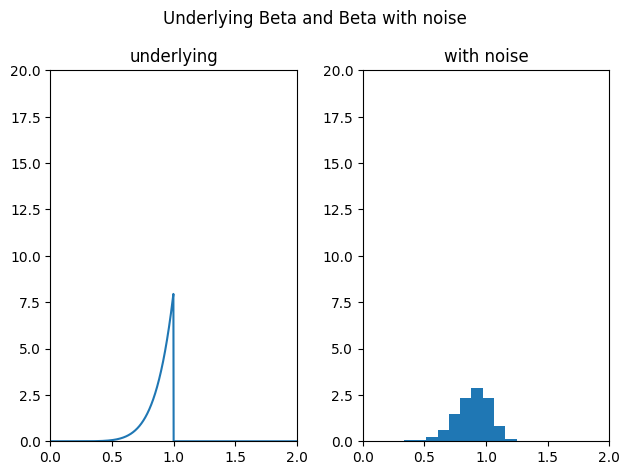

In [4]:
#generate non-weibull data, following beta distribution
beta_data = beta.rvs(a=8, b=1, size=n)
#add noise
beta_data = beta_data + noise
#all positive data
beta_data = np.abs(beta_data)

#generate the pdf with the same parameters that were used for generating the data
curve_x = np.linspace(0, 2, 1000)
beta_pdf = beta.pdf(curve_x, a=8, b=1)

title='Underlying Beta and Beta with noise'
subs = ['underlying', 'with noise']
fig, ax = plt.subplots(1, 2)
ax[0].plot(curve_x, beta_pdf)
ax[1].hist(beta_data, density=True)

for idx in range(2): 
    ax[idx].set_xlim(0, 2.0)
    ax[idx].set_ylim(0, 20.0)
    ax[idx].set_title(subs[idx])
plt.suptitle(title)
fig.tight_layout()
fig.show()

****
# Utility functions 

In [5]:
def plot_weibull_distributions(params1, params2):
    shape1, scale1 = params1
    shape2, scale2 = params2
    
    # Create Weibull distribution objects
    weibull_dist1 = weibull_min(c=shape1, scale=scale1)
    weibull_dist2 = weibull_min(c=shape2, scale=scale2)
    
    # Generate x values for the plot
    x = np.linspace(0, max(scale1, scale2) * 2, 1000)
    
    # Calculate probability density function values for each distribution
    pdf1 = weibull_dist1.pdf(x)
    pdf2 = weibull_dist2.pdf(x)
    
    # Plot the distributions
    plt.plot(x, pdf1, label=f'Weibull ({shape1:.2f}, {scale1:.2f})')
    plt.plot(x, pdf2, label=f'Weibull ({shape2:.2f}, {scale2:.2f})')
    plt.xlabel('x')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.title('Weibull Distributions')
    plt.show()

****
# Model setup 

In [6]:
def weibull_nll_old(X, lambda_, k): 
    # todo: what is this?? the likelihood fn seems wrong 
    weibull_pdf = (k / lambda_) * (X / lambda_)**(k - 1) * torch.exp(-((X / lambda_)**k))
    nll = -torch.log(weibull_pdf).mean()  
    return nll

In [7]:
def train_loop_lbfgs(model, optimizer, data_tensor, closure, n=1000): 
    # todo: delete 
    losses = []
    for i in range(n):
        optimizer.step(closure)
        loss = closure()
        losses.append(loss) 
    return losses

In [8]:
class Model(nn.Module):
    """Custom Pytorch model for gradient optimization.
    """
    def __init__(self):        
        super().__init__()
        # initialize weights with random numbers
        weights = torch.distributions.Uniform(0, 4).sample((2,))
        # make weights torch parameters
        self.weights = nn.Parameter(weights)        
        
    def forward(self, X):
        """Implement function to be optimised. In this case, a 2-parameter Weibull
        distribution (f(x) = (k / lambda) * (x / lambda)^(k - 1) * exp(-(x / lambda)^k)),
        """
        lambda_, k = self.weights
        weibull_pdf = (k / lambda_) * (X / lambda_)**(k - 1) * torch.exp(-((X / lambda_)**k))
        
        return weibull_pdf


In [9]:
def train_loop(model, optimizer, data_tensor, n=1000): 
    losses = []
    print('scale, shape, loss \n')
    for i in range(n):
        preds = model(data_tensor)
        # loss = F.mse_loss(preds, data_tensor).sqrt()  # todo: use neg log likelihood? 
        lambda_, k = model.weights
        loss = weibull_nll(data_tensor, lambda_, k)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss) 
        # print(f'{lambda_}, {k}, {loss}')
        
    return losses

In [10]:
def weibull_nll(data, lambda_, k): 
    log_likelihood = torch.sum(torch.log(k / lambda_) + (k - 1) * torch.log(data / lambda_) - (data / lambda_) ** k)
    nll = -log_likelihood
    return nll

****
# Using Adam optimizer on Weibull data 

scale, shape, loss 


Fitted params: shape=0.863, scale=1.026

Actual params: shape=0.8, scale=1

abs(actual minus predicted) for shape=0.23

abs(actual minus predicted) for scale=0.14


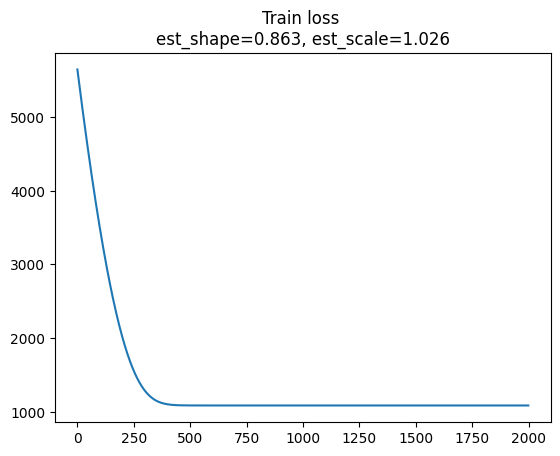

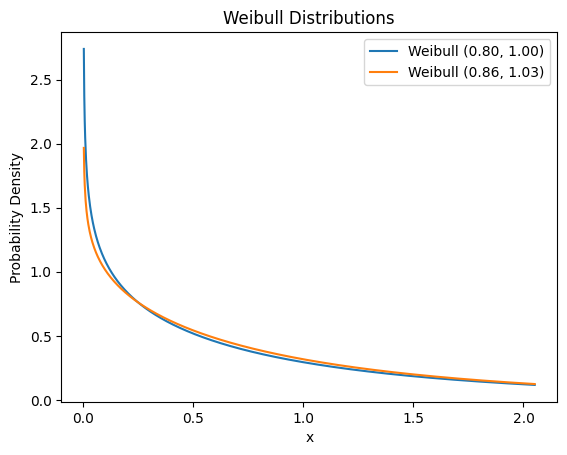

Actual shape=0.8


In [11]:
# min-max scale to speed up convergence. This means we won't get correctly estimated scale param, 
# but shape param will remain same. 
# weibull_data_scaled = [(x - weibull_data.min()) / (weibull_data.max() - weibull_data.min()) for x in weibull_data]
weibull_tensor = torch.tensor(weibull_data, dtype=float).reshape(-1,1)

m = Model()
opt = torch.optim.Adam(m.parameters(), lr=.01, amsgrad=True)
# opt = torch.optim.SGD(m.parameters(), lr=.1)

losses = train_loop(m, opt, data_tensor=weibull_tensor, n=2000)
losses = [loss.detach().numpy().tolist() for loss in losses]
fitted_params = m.weights

estimated_scale = fitted_params.detach().numpy()[0]
estimated_shape = fitted_params.detach().numpy()[1]
print(f'\nFitted params: shape={estimated_shape:.3f}, scale={estimated_scale:.3f}')
print(f'\nActual params: shape={shape}, scale={scale}')
print(f'\nabs(actual minus predicted) for shape={np.abs(shape-fitted_params[0].detach().numpy()):.2f}')
print(f'\nabs(actual minus predicted) for scale={np.abs(scale-fitted_params[1].detach().numpy()):.2f}')

plt.plot(losses)
plt.title(f'Train loss \nest_shape={estimated_shape:.3f}, est_scale={estimated_scale:.3f}')
# plt.ylim(bottom=0)
plt.show()

plot_weibull_distributions((shape, scale), (estimated_shape, estimated_scale))
print(f'Actual shape={shape}')

# Using Adam optimizer on Beta data 

scale, shape, loss 


Fitted params: shape=7.598, scale=0.948


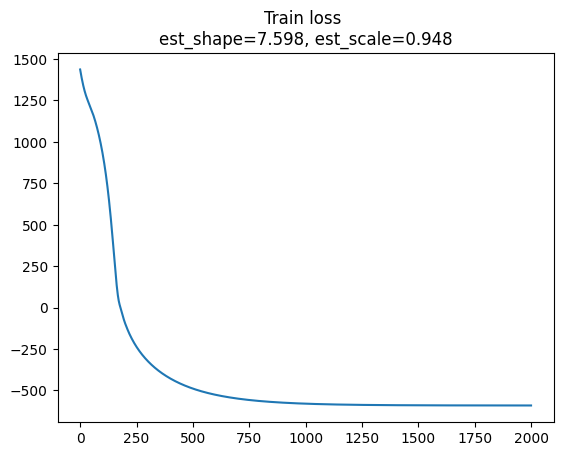

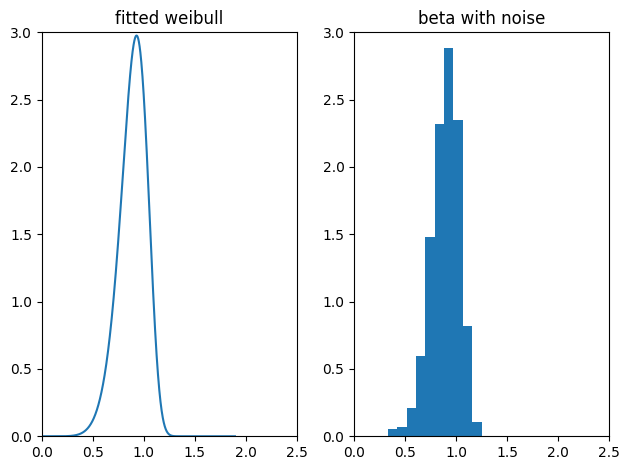

In [12]:
beta_tensor = torch.tensor(beta_data, dtype=float).reshape(-1,1)

m = Model()
opt = torch.optim.Adam(m.parameters(), lr=.01, amsgrad=True)
# opt = torch.optim.SGD(m.parameters(), lr=.1)

losses = train_loop(m, opt, data_tensor=beta_tensor, n=2000)
losses = [loss.detach().numpy().tolist() for loss in losses]
fitted_params = m.weights

estimated_scale = fitted_params.detach().numpy()[0]
estimated_shape = fitted_params.detach().numpy()[1]
print(f'\nFitted params: shape={estimated_shape:.3f}, scale={estimated_scale:.3f}')
# print(f'\nActual params: shape={shape}, scale={scale}')
# print(f'\nabs(actual minus predicted) for shape={np.abs(shape-fitted_params[0].detach().numpy()):.2f}')
# print(f'\nabs(actual minus predicted) for scale={np.abs(scale-fitted_params[1].detach().numpy()):.2f}')

plt.plot(losses)
plt.title(f'Train loss \nest_shape={estimated_shape:.3f}, est_scale={estimated_scale:.3f}')
# plt.ylim(bottom=0)
plt.show()


txt = 'Fitted weibull vs beta_data_with_noise'
subs = ['fitted weibull', 'beta with noise']
fig, ax = plt.subplots(1, 2)
weibull_dist = weibull_min(c=estimated_shape, scale=estimated_scale)
x = np.linspace(0, estimated_scale*2, 1000)
weibull_pdf = weibull_dist.pdf(x)
ax[0].plot(x, weibull_pdf, label='fitted weibull')
ax[1].hist(beta_data, density=True)

for idx in range(2): 
    ax[idx].set_title(subs[idx])
    ax[idx].set_xlim(0, 2.5)
    ax[idx].set_ylim(0, 3.0)

fig.tight_layout()
fig.show()


****
# Using LBFGS 

In [13]:
# m2 = Model()
# x_ = Variable(weibull_tensor, requires_grad=True)
# lbfgs = torch.optim.LBFGS(m2.parameters(), history_size=100, max_iter=40)

# train_loop_lbfgs(m2, lbfgs, weibull_tensor, closure=lbfgs_closure, n=10)

In [14]:
model2 = Model()

# Create the optimizer
optimizer = torch.optim.LBFGS(model2.parameters(), lr=0.1)

# Training loop
num_iterations = 500
for i in range(num_iterations):
    def closure():
        optimizer.zero_grad()
        weibull_pdf = model2(weibull_tensor)
        lambda_, k = model2.weights
        loss = weibull_nll(weibull_tensor, lambda_, k)
        # print(f'{lambda_}, {k}, {loss}')
        loss.backward()
        return loss

    optimizer.step(closure)

# Print the fitted parameters
print("Fitted parameters:", model2.weights)

Fitted parameters: Parameter containing:
tensor([1.0256, 0.8626], requires_grad=True)
